<a href="https://colab.research.google.com/github/u6yuvi/DL-POC/blob/main/NLP/Text_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Gdrive + Kaggle CLI

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')
#* updating filepath to your Google Drive

# #Make sure you have this path available in your google drive
# filepath="/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"u6yuvi","key":"62a8a2d8ea2f0d4d01b1bd812b047418"}'}

In [8]:
#! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 46.7MB/s]
 21% 5.00M/23.4M [00:02<00:07, 2.51MB/s]
100% 23.4M/23.4M [00:02<00:00, 11.1MB/s]
 68% 18.0M/26.3M [00:02<00:02, 3.75MB/s]
100% 26.3M/26.3M [00:02<00:00, 12.7MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 43.4MB/s]


In [13]:
!unzip -qq train.csv.zip
#!unzip -qq test.zip

#Install

In [22]:
!pip install -q transformers

In [21]:
!pip install -U -q watermark

In [30]:
%reload_ext watermark
%watermark -v -p pandas,numpy,transformers

CPython 3.6.9
IPython 5.5.0

pandas 1.1.4
numpy 1.18.5
transformers 4.0.0


# Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch import nn , optim
from torch.utils.data import Dataset,DataLoader
%matplotlib inline

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
df = pd.read_csv("train.csv")
df.shape

(159571, 8)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [20]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


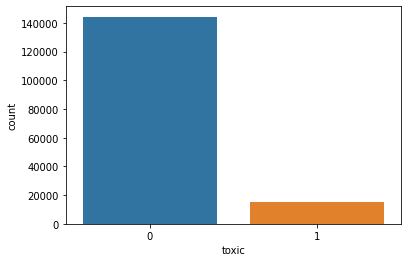

In [40]:
sns.countplot(df.toxic)

# Data Preprocessing


In [43]:
df.comment_text.tolist()[:5]

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

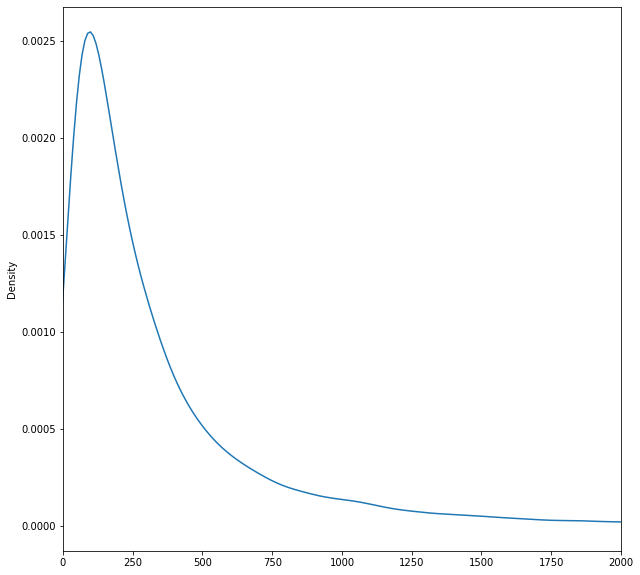

In [48]:
#Length of the comments_text
df.comment_text.apply(lambda x : len(x)).plot(kind = 'kde',xlim = (0,2000),figsize=(10,10))


# Tokenizer

In [50]:
from transformers import BertTokenizer

In [51]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [56]:
sentence = df.comment_text.iloc[0]
tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'Sentence:{sentence}')
print(f'Tokens:{tokens}')
print(f'Token_ids:{token_ids}')

Sentence:Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Tokens:['Ex', '##p', '##lana', '##tion', 'Why', 'the', 'edit', '##s', 'made', 'under', 'my', 'user', '##name', 'Hard', '##core', 'Metal', '##lica', 'Fan', 'were', 'reverted', '?', 'They', 'weren', "'", 't', 'van', '##dal', '##isms', ',', 'just', 'closure', 'on', 'some', 'GA', '##s', 'after', 'I', 'voted', 'at', 'New', 'York', 'Doll', '##s', 'FA', '##C', '.', 'And', 'please', 'don', "'", 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'I', "'", 'm', 'retired', 'now', '.', '89', '.', '205', '.', '38', '.', '27']
Token_ids:[16409, 1643, 20592, 2116, 2009, 1103, 14609, 1116, 1189, 1223, 1139, 4795, 16124, 9322, 9475, 9953, 9538, 16061, 1127, 17464, 136, 1220, 3920, 112, 189, 3498, 6919, 16762, 1

In [57]:
assert len(tokens) == len(token_ids)

# Special Tokens

In [58]:
print(tokenizer.sep_token,tokenizer.sep_token_id)

[SEP] 102


In [59]:
print(tokenizer.cls_token,tokenizer.cls_token_id)


[CLS] 101


In [60]:
print(tokenizer.pad_token,tokenizer.pad_token_id)

[PAD] 0


In [61]:
print(tokenizer.unk_token,tokenizer.unk_token_id)

[UNK] 100


In [ ]:
df_comment.iloc[17]

In [112]:
enc = tokenizer.encode_plus(df.comment_text.iloc[18],
                      max_length = 128,
                      truncation = True,
                      add_special_tokens = True,  ##[CLS] +[SEP]
                      return_token_type_ids = False,
                      return_attention_mask = True,
                      return_tensors = 'pt')

In [113]:

vars(enc)

{'_encodings': None,
 '_n_sequences': None,
 'data': {'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1]]),
  'input_ids': tensor([[  101,  1109, 12107,  9552, 27744,  1182,  1553,  1189,  1185,  2305,
             118,  1725,  1136,  6982,  1106,  1511,  9001,  1113,   155,  7490,
           17784,  1968, 21150,   112,   188,  3674,  1106,  1511,  1167,  1869,
             136,   102]])}}

In [114]:
print(len(enc["attention_mask"][0]),len(enc["input_ids"][0]))

32 32


In [115]:
tokenizer.convert_ids_to_tokens(enc['input_ids'][0])

['[CLS]',
 'The',
 'Mi',
 '##tsu',
 '##rug',
 '##i',
 'point',
 'made',
 'no',
 'sense',
 '-',
 'why',
 'not',
 'argue',
 'to',
 'include',
 'Hindi',
 'on',
 'R',
 '##yo',
 'Sa',
 '##ka',
 '##zaki',
 "'",
 's',
 'page',
 'to',
 'include',
 'more',
 'information',
 '?',
 '[SEP]']

# Create Custom Pytorch DataLoader


In [116]:
class ToxicDataset(Dataset):
  def __init__(self,comment,target,tokenizer,max_len):
    self.comment = comment
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comment)

  def __getitem__(self,item):
    comment = str(self.comment[item])
    target  = self.target[item]

    encoding = self.tokenizer.encode_plus(comment,
                      max_length = 128,
                      truncation = True,
                      add_special_tokens = True,  ##[CLS] +[SEP]
                      return_token_type_ids = False,
                      return_attention_mask = True,
                      return_tensors = 'pt')
    print(len(encoding["attention_mask"][0]),len(encoding["input_ids"][0]))
    return {
        "comment_text":comment,
        "input_ids":encoding["input_ids"].flatten(),
        "attention_mask":encoding["attention_mask"].flatten(),
        "targets":torch.tensor(target,dtype = torch.long)
    }

In [80]:
df_train,df_test  = train_test_split(df,test_size = 0.2,random_state=123)
df_val,df_test  = train_test_split(df_test,test_size = 0.5,random_state=123)

In [82]:

df_train.shape,df_val.shape,df_test.shape

((127656, 8), (15957, 8), (15958, 8))

# Create DataLoader



In [121]:
def comment_data_loader(df,tokenizer,max_len,batch_size):
  toxic_dataset = ToxicDataset(comment = df.comment_text.to_numpy(),
                               target = df.toxic.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = max_len)
  
  return DataLoader(toxic_dataset,batch_size=batch_size,num_workers=4)

In [118]:
MAX_LEN = 128
BATCH_SIZE = 2
train_data_loader = comment_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)

In [123]:
df_train.comment_text.iloc[18]

'Blocked\nI have blocked this IP address as a  because it has been used by a single editor using multiple accounts in a manner that appears to be deceptive. Most particularly, however, is this edit, which implied that this editor is an administrator (which is not the case).  I have consulted with another checkuser prior to applying this block, and his findings concur with mine.'

In [119]:
data = next(iter(train_data_loader))
data.keys()

47 47
29 29
78 78
49 49
25 25
33 33
34 34
128 128
79 79
7 7
75 75
42 42
16 16
31 31
35 35
128 128
52 52
109 109


RuntimeError: ignored